In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import sklearn
import urllib
import os

In [2]:
url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
file_name = 'green_tripdata_2015-09.csv'

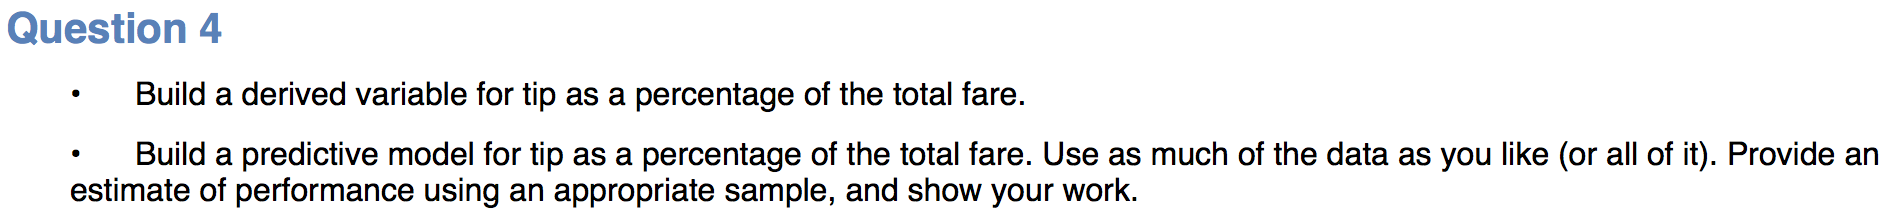

In [3]:
# Download the September 2015 dataset
if os.path.exists(file_name): # Check whether we already get the data
    data = pd.read_csv(file_name)
else: # If not, download and save
    data = pd.read_csv(url)
    data.to_csv(url.split('/')[-1])

# 4.1 Build a derived variable for tip as percentage of the total fare
    
<font size = 3.5> Tip percentage is calculated by Tip_amount divided by Total amount. But we will **re-compute** it after we clean the data( replace negative tips by their absolute values.)

In [4]:
data['Tip_percentage'] = data.apply(
    lambda x: round((x.Tip_amount/x.Total_amount)*100, 2) if x.Total_amount else 0.00,axis = 1)

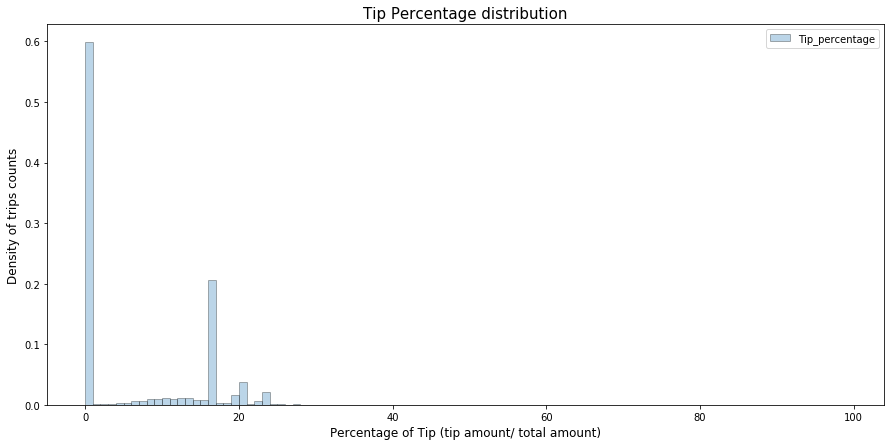

In [5]:
f, ax = plt.subplots(figsize = (15,7))
break_points = [i/1 for i in range(0,100)]
ax.set_title('Tip Percentage distribution',size = 15)
ax.set_xlabel('Percentage of Tip (tip amount/ total amount)', size = 12)
ax.set_ylabel('Density of trips counts', size = 12)
ax.hist(data.Tip_percentage, density = True, edgecolor='black', alpha = 0.3,
        bins = break_points)
ax.legend()

# 4.2 Build a predictive model


<font size = 4>
**Overview**
    
- 4.2.0. Data Sampling: Sample data appropriately

- 4.2.1. Data Cleaning: Deal with missing/fake data
    
- 4.2.2. Feature Engineering & Selection: Generate new meaniful features and select features to make model more interpretable.
   
- 4.2.3. Model Construction & Evaluation: RF and LR 

- 4.2.4. Conclusions:

   

## 4.2.0 Data Sampling: Sample data appropriately


<font size = 3.5>The initial data are 1494926 rows and 27 columns. We will build our model without cash trips. And we will drop columns : Tip_amount and Total_amount. Besides, we would split train and test dataset by the day of month. Their size ratio are 7:3.


2. Avoid leaking information: Drop **Total_amount**, **Tip_amount**:

    Since Tip_percentage = Tip_amount/Total_amount. If we already know these 2 features we don't need to provide a predictive model. Besides, we find that total amount is the sum of 'Fare_amount', 'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'improvement_surcharge'. If we keep any one of them, we could calculate the other one. So we should drop all of them.( We keep Tip_amount for re-computing Tip_percentage in data cleaning part and will drop it before model construction.)
    
3. Sampling 10,0000 records for model efficeincy.
    
3. Train test Split: Stratified split train and test data 7:3 by the day of month. 

    We split the train and test stratified by the day of month. An alternative would be split the data by whether trips get tips. But we think that may destroy tip percentage distribution. So we split data by the day of month.
    
Since we still need to fix tip amount values and recompute Tip_amount after we clean the data, so we decide to split train and test data after cleaning data. It would be fine because we don't apply and supervised method to fix data, and we can garuante that there is no information leak.

In [6]:
from sklearn.model_selection import train_test_split
# Code for check discrete features
def check_discrete_feature(column_name, df):
    if column_name not in df.columns:
        print('No such column in dataframe.')
    else:
        tmp_df = df[column_name].value_counts().to_frame().reset_index()
        tmp_df.columns = [column_name,'Counts']
        tmp_df['Proportion'] = round(tmp_df.Counts/df.shape[0],4)
        print('-------------{} value counts-------------'.format(column_name))
        print(tmp_df)
    return

# Sampling 
def sampling_data(df):
    # Drop cash trips
    cash_trips = df[df.Payment_type==2]
#     sampled_df = df[df.Payment_type!=2]
    sampled_df = df
    # Drop Total_amount
    sampled_df = sampled_df.drop(['Total_amount'], axis=1)
    sampled_df = sampled_df.sample(n = 100000)
    return sampled_df, cash_trips

In [7]:
sampled_df, cash_trips = sampling_data(data)

In [8]:
sampled_df.shape

(100000, 21)

## 4.2.1 Data Cleaning: Deal with missing/fake data
<font size = 3.5>
According to green taxi data dictionary: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf
And Taxicab Rate of Fare: http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml

There are some values are invalid and missing. Here is the summary of how we deal with these data. And following part is how we find these data invalid.

2. Drop Missing feature **Ehail_fee**: The value in this feature totally missing, so just drop it.
3. Missing **Location** data: 0.23% of location data is missing. In this part, we didn't find a efficient way to fix it. But we will assign a district code for missing location data in **feature engineering** part.

3. Category data: 
    - **RateCodeID**: 6 records have invalid value 99, drop these records out because there are only 6 rows and their Dropoff location and Total amount are invalid either.     
4. Numerical data:
    - **Extra**: There are 0.08% data has invalid value that not in [0.0,0.5,1.0]. We assume nagative data are made by input error, so we replace them by their absolut values. And We replace other Extra by 0.5 or 1.0 or 0 base on their Pickup_hour and wether the pickup day is workday. 

    Extra only includes the \$0.50 and \$1 rush hour and overnight charges. There is a daily 50-cent surcharge from 8pm to 6am. There is a \$1 surcharge from 4pm to 8pm on weekdays, excluding holidays.
    - **MTA_tax**: 0.15% data has invalid negative value, we replace them with their absolute value. 
    
    \$0.50 MTA tax that is automatically triggered based on the metered rate in use. There is a 50-cent MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
    
    - **Fare_amount**: 0.15% data has negative value, we replace them with their absolute value. 0.33% of value is smaller than 2.50 (the intial charge of fare amount), we simpliy drop them out
    
    - **Improvement_surcharge**: 0.15% data has invalid negative value, we replace them with their absolute value
    - **Tolls_amount**: 7 records have invalid negative value, we replace them with absolute value
    - **Tip_amount**: 38 records has invalid negative value, we replace them with their absolute value
    - **Trip_distance**: 1.38% of trip distance is 0, which we think there might be missing value. There are several ways to fix it. We assume that trips distance with same trip duration in the same hour of the same day would have similar values. So we fix 0-distance trips whose duration longer more than 3 mins with the rest trips distance mean( same duaration, same hour of day, same day). An alternative is to applie KNN or regression model to fix it. Since the proportion is relatively small and time is limited, we skip this part.
4. **Tip_percentage**: It was tip amount divided by total amount. Since there are some adjustments in features above, so the tip_percentage should be re-calculated by correct values 

6. After we create some new features, we would drop some invalid trip records: trip duration is less than 60s.

In [12]:
# Code for cleaning data
def clean_data(df):
    # the function to make up feature extra
    def make_up_extra(x):
        weekend = [5,6,12,13,19,20,26,27]
        if x.Extra in [0.0, 0.5, 1.0]:
            return x.Extra
        elif x.Extra == -0.5:
            return 0.5
        elif x.Extra == -1.0:
            return 1.0
        elif x.Pickup_hour >= 16 & x.Pickup_hour<20 & x.Pickup_day not in weekend:
            return 1.0
        elif x.Pickup_hour>=20 or x.Pickup_hour<6:
            return 0.5
        else: 
            return 0
    # Drop feature Ehail_fee
    df_clean = df.drop(['Ehail_fee'],axis=1)
    # Drop trips with invalid RateCodeID 99
    df_clean = df_clean[df_clean.RateCodeID!=99]
    # Create feature day to help make up feature extra
    df_clean['Pickup_day'] = pd.to_datetime(df_clean.lpep_pickup_datetime).apply(lambda x: x.day)
    df_clean['Pickup_hour'] = pd.to_datetime(df_clean.lpep_pickup_datetime).apply(lambda x: x.hour)
    # Deal with missing data in extra
    df_clean.Extra = df_clean.apply(lambda x: make_up_extra(x), axis = 1)
    # replace negative data in 'Fare_amount', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'improvement_surcharge'
    negative_features = ['Fare_amount', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'improvement_surcharge']
    for feature in negative_features:
        df_clean[feature] = df_clean[feature].apply(lambda x : -x if x <0 else x)
    df_clean = df_clean[df_clean.Fare_amount>=2.50]
    df_clean['Tip_percentage'] = df_clean.apply(
        lambda x: round(100 * x.Tip_amount/sum((x[feature] for feature in negative_features)),2),
        axis = 1)  
    Trip_duration= (pd.to_datetime(df.Lpep_dropoff_datetime)
                -pd.to_datetime(df.lpep_pickup_datetime)).dt.total_seconds()
    df_clean = df_clean[Trip_duration>60]
    return df_clean

In [13]:
df_clean = clean_data(sampled_df)

/Users/youyang/virtualenvs/AML/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [14]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df_clean.drop(['Tip_percentage'],axis=1),
                                                            df_clean.Tip_percentage,
                                                            test_size = .2
                                                            )
                            
print('We get our clean train test dataset.\n '
      'X_train_raw: {x_train}\n '
      'X_test_raw: {x_test}'.format(x_train = X_train_raw.shape,
                                    x_test = X_test_raw.shape))

We get our clean train test dataset.
 X_train_raw: (78404, 21)
 X_test_raw: (19602, 21)


In [15]:
X_train_raw.columns

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'improvement_surcharge', 'Payment_type',
       'Trip_type ', 'Pickup_day', 'Pickup_hour'],
      dtype='object')

### The following part would explain how we find these missing features and thier patterns

There are 52.4% trips are paid by cash and 46.9% trips are paid by credit cards. 0.4% trips are paid no charge, 0.3% trips are disputed. And as we look into trips that paid by cash, it's unlikely that only 2 trips get tips in reality. So we assume that the tip amounts are missing in cash trips.

**Due to time limitation**, we regard cash trip tip information as noises and it's reasonable to filter these data out in our predictive model. If time permitted, we assume tips percentage in cash-paid trips would have similar distribution as card-paid trips, so it would became a **Semi-supervised training** problem.

<font size = 4> **Missing values in Feature Ehail_fee**</font>

Feature **Ehail_fee** total missng. We can just drop it.

In [16]:
print(sampled_df.Ehail_fee.describe())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Ehail_fee, dtype: float64


<font size = 4> **Missing values in Location**</font>

0.24% of location informations are partly missing. 

In [17]:
data[(data.Pickup_latitude==0)|(data.Pickup_longitude==0)|
    (data.Dropoff_latitude==0)|(data.Dropoff_longitude==0)].shape[0]/data.shape[0]

0.0023740305540207343

<font size = 4>**Category data**

In [18]:
Category_features = ['VendorID', 'Store_and_fwd_flag', 'RateCodeID', 'Payment_type', 'Trip_type ']

<font size = 3.5> **RateCodeID** </font>

97.85% of trip would be standard rate. Followed by negotiated rate with 1.72% and JFK rate with 0.3%. The RateCodeID 99 doesn't make sense. So let's look inside. It seems there are some problem with Dropoff location and total amount. And it only 4 rows, kick them out would be fine.

In [19]:
check_discrete_feature(Category_features[2], data)
data[data.RateCodeID == 99]

-------------RateCodeID value counts-------------
   RateCodeID   Counts  Proportion
0           1  1454464      0.9729
1           5    33943      0.0227
2           2     4435      0.0030
3           3     1117      0.0007
4           4      925      0.0006
5           6       36      0.0000
6          99        6      0.0000


,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,Tip_percentage
15736,1,2015-09-01 12:20:32,2015-09-01 12:21:10,N,99,-73.906456,40.871605,-73.906464,40.871605,1,...,0.0,0.0,0.0,0.0,NaN,0.0,0.00,2,1.0,0.0
658365,1,2015-09-13 21:30:27,2015-09-13 21:30:27,N,99,-73.950455,40.670223,0.000000,0.000000,1,...,0.0,0.0,0.0,0.0,NaN,0.0,0.00,2,1.0,0.0
984680,1,2015-09-20 05:49:23,2015-09-20 09:49:23,Y,99,-73.932220,40.800476,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,NaN,0.0,17.30,1,NaN,0.0
985599,1,2015-09-20 06:27:40,2015-09-20 10:27:40,Y,99,-73.899170,40.746098,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,NaN,0.0,12.35,1,NaN,0.0
985620,1,2015-09-20 06:22:12,2015-09-20 10:22:12,Y,99,-73.957703,40.717789,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,NaN,0.0,23.15,1,NaN,0.0
1070054,1,2015-09-22 06:43:33,2015-09-22 10:43:33,Y,99,-73.928520,40.692528,0.000000,0.000000,0,...,0.0,0.0,0.0,0.0,NaN,0.0,20.30,3,NaN,0.0


<font size = 3.5> **Other categorical features we explore(no missing values)** </font>

In [20]:
check_discrete_feature(Category_features[0], data)

-------------VendorID value counts-------------
   VendorID   Counts  Proportion
0         2  1169099       0.782
1         1   325827       0.218


77.91% data are provided by VeriFone Inc. The rest of them provided by Creative Mobile Technologies, LLC.

In [21]:
check_discrete_feature(Category_features[1], data)

-------------Store_and_fwd_flag value counts-------------
  Store_and_fwd_flag   Counts  Proportion
0                  N  1486192      0.9942
1                  Y     8734      0.0058


99.5% data are not store and fwd trip. As we found above, the store and fwd trips record trip distance to 1 decimals.

In [22]:
check_discrete_feature(Category_features[3], data)

-------------Payment_type value counts-------------
   Payment_type  Counts  Proportion
0             2  783699      0.5242
1             1  701287      0.4691
2             3    5498      0.0037
3             4    4368      0.0029
4             5      74      0.0000


There are 52.4% trips are paid by cash and 46.9% trips are paid by credit cards. 0.4% trips are paid no charge, 0.3% trips are disputed.

In [23]:
check_discrete_feature(Category_features[4], data)

-------------Trip_type  value counts-------------
   Trip_type    Counts  Proportion
0         1.0  1461506      0.9776
1         2.0    33416      0.0224


98.3% of trips are street-hail and 1.68% of are dispatched.

<font size = 4>**Numerical data**

In [24]:
Numerical_features = ['lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'improvement_surcharge',
       'Total_amount']

<font size = 3.5> **Extra** </font>

Currently, **Extra** only includes the \$0.50 and \$1 rush hour and overnight charges. There is a daily 50-cent surcharge from 8pm to 6am. There is a $1 surcharge from 4pm to 8pm on weekdays, excluding holidays. 

We assume nagative data are made by input error, so we can replace them by their absolut value. Beside, there are some trips **Extra** that not in 0.50/0.00/1.0, we replace their **Extra** by their **Pickup_hour** and wether the pickup day is workday.

In [25]:
check_discrete_feature('Extra',data)

-------------Extra value counts-------------
   Extra  Counts  Proportion
0   0.00  684524      0.4579
1   0.50  566414      0.3789
2   1.00  242728      0.1624
3  -0.50     889      0.0006
4  -1.00     365      0.0002
5   0.25       3      0.0000
6  12.00       1      0.0000
7  -0.72       1      0.0000
8   0.02       1      0.0000


<font size = 3.5> **MTA_tax** </font>

$0.50 MTA tax that is automatically triggered based on the metered rate in use. There is a 50-cent MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties. We replace negative value with their absolute value.

In [26]:
check_discrete_feature('MTA_tax',data)

-------------MTA_tax value counts-------------
   MTA_tax   Counts  Proportion
0      0.5  1457171      0.9747
1      0.0    35568      0.0238
2     -0.5     2187      0.0015


<font size = 3.5> **Improvement_surcharge** </font>

$0.30 improvement surcharge assessed on hailed trips at the flag
drop. The improvement surcharge began being levied in 2015.

In [27]:
check_discrete_feature('improvement_surcharge',data)

-------------improvement_surcharge value counts-------------
   improvement_surcharge   Counts  Proportion
0                    0.3  1457770      0.9751
1                    0.0    34941      0.0234
2                   -0.3     2215      0.0015


<font size = 3.5> **Tolls amount** </font>

In [28]:
print('Number of records with negative Tolls amount:',data[data.Tolls_amount<0].shape[0])

Number of records with negative Tolls amount: 7


<font size = 3.5> **Fare amount** </font>

According to TaxiCrab Rate of Fare, the intial charge should be 2.5, so any value less than 2.5 would be consider invalid.

In [29]:
print('Percentage of data with negative Fare amount:', data[data.Fare_amount<0].shape[0]/data.shape[0])
print('Percentage of data with invalid amount:', data[abs(data.Fare_amount)<2.5].shape[0]/data.shape[0])

Percentage of data with negative Fare amount: 0.0016168024370437064
Percentage of data with invalid amount: 0.0033827761374141596


<font size = 3.5> **Tip amount** </font>

In [30]:
print('Number of records with negative Tip amount:',data[data.Tip_amount<0].shape[0])

Number of records with negative Tip amount: 38


<font size = 3.5> **Trip distance** </font>

1.3% trips has 0 miles trips distance, we think there might be some missing trip values assigned to 0. And we will further explore in feature engineering part.

In [31]:
data[data.Trip_distance==0].shape[0]/data.shape[0]

0.013774594862889534

<font size = 3.5> **Passenger_count** </font>

84% trips have 1 passenger. And we noticed that there are some trips have 0 passenger. Dive into it and we find most RateCodeIDs are 5(negotiated fare rate). Since we didn't find any other information could indicate passengers number, we just keep it as original.

In [32]:
check_discrete_feature('Passenger_count',data)

-------------Passenger_count value counts-------------
   Passenger_count   Counts  Proportion
0                1  1255832      0.8401
1                2   115014      0.0769
2                5    57907      0.0387
3                3    33812      0.0226
4                6    22091      0.0148
5                4     9769      0.0065
6                0      440      0.0003
7                8       30      0.0000
8                9       16      0.0000
9                7       15      0.0000


## 4.2.2 Feature Engineering & Feature Selection: Generate new meaniful features and select features to make model more interpretable.

<font size = 3.5>
In this part, we aims to construct new features that more businiess-valuable. After that, we will do feature selection.

Here is the summary of what we create and how we do feature selection.

**Feature Engineering**
1. Location Fetures: Pickup_x, Pickup_y, Dropoff_x, Dropoff_y, Pickup_district, Dropoff_district.
   - These features show pickup & dropoff location information. To easliy visualize location, we change the coordinate from long & lat to x & y. We assume that tip preference may relate to pickup/dropoff location. For instance, passengers whose destination is wall street might pay more tips because they are rich.
   - District data are assigned by location cluster number according to  'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude'. We apply Kmeans to cluster the location since we assume each ditrict would have similar region size. Another advantage is that it's easy for us to control the cluster number. An **alternative** is to assign district by postalcode. We tried but current API are quit slow and there is no clear lantitude and longtitude boundary data on the internet. So we just cluster these location Information and assign them with cluster number.
   
2. Time Features: Pickup_hour, Dropoff_hour, Pickup_weekday, Pickup_day, Workday.
    - These features indicate pickup/dropoff time information. We assume that passangers would have different tip preferrence depends on time. For instance, passengers might pay less tips during rush hour or workday.
    - These were extracted from  'lpep_pickup_datetime' & 'Lpep_dropoff_datetime'. Pickup_hour & Dropoff_hour are hour of 'lpep_pickup_datetime' & 'Lpep_dropoff_datetime'. Pickup_weekday is 0 for Sunday, 1 for Monday, 2 for Tuesday and so on. Pickup_day is the day of the month. Workday is 1 if pickup time is workday else 0.
    
3. Trip Duration: Trip_duration.
    - This features indicate how long a trip would take. Passangers may have different tip preferrence depends on duration. For instance, passengers might pay less tips during rush hour or workday. We assume the longer trip_duration results in more tips.
    - Trip_duration = 'Lpep_dropoff_datetime' - 'lpep_pickup_datetime'. The unit is minute.

4. Airports Trip Indicator: Airport_trip. 
    - It indicates whether this trip dropoff or pickup near airports. Passengers may pay more tips for airport trips for more luggage. 
    - It would be 1 for pickup at JFK, 2 for dropoff at JFK, 3 for pickup at Newark, 4 for dropoff at Newark, else 0

5. Speed Feature: Speed. 
    - It shows the speed of trips. We assume that tip preference may also related to speed. For instance, passengers would thank drivers for faster speed for saving their time.
    - Speed = Trip_distance / Trip_duration unit: miles/hour

5. Categorical data onehot encoding: it’s not necessary for tree models. But in sklean, we still need to do this. 

6. Scale: Since we are going to use tree models, we dont need to normalize each features.

7. PolynomialFeature: We tried, but the result didn'y significantly improve.

**Feature Selection**
1. Covariance: Find 8 pairs of highly correlated features 
    - Drop location features: 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude'
    - Keep 'Trip_distance' & 'Fare_amount' both
    - Keep 'Pickup_hour', drop 'Dropoff_hour'
    - Keep 'Pickup_x', 'Pickup_y', 'Dropoff_x', 'Dropoff_y'
2. Scatter Continuous feature Vs Tip percentage: Get some insights
3. Lasso Model: We would try if time permitted. We could train a basic model with L1 objective function. And then drop features those have low feature importance.



### Feature Engineering

In [33]:
from sklearn.cluster import KMeans

def location_cluster(location_dataframe, cluster_number):
    location_pickup = location_dataframe[['Pickup_x','Pickup_y']]
    location_pickup.columns = ['X','Y']
    location_dropoff = location_dataframe[['Dropoff_x','Dropoff_y']]
    location_dropoff.columns = ['X','Y']
    location = pd.concat([location_pickup, location_dropoff], keys=['Pickup','Dropoff'])
    location.index.names = ['Pick_Drop','Index']
        
    km = KMeans(n_clusters= cluster_number)
    km.fit(location[['X','Y']])
    location['label'] = km.labels_
        
    # Plot location clustering result
    f, ax = plt.subplots(figsize = (15,8))
    plt.xlim(29.40, 29.52) 
    plt.ylim(-37.63, -37.54)
    ax.scatter(location.X, location.Y, s=.3, alpha=0.03, c = location.label)

    plt.title('Location clustering resluts',size = 15)
    plt.xlabel('X',size = 15) 
    plt.ylabel('Y',size = 15)
    plt.axis('equal')
    plt.xlim(29.40, 29.52) 
    plt.ylim(-37.64, -37.52)
    return location
def lat_lng_to_pixels(lat, lng):
    lat_rad = lat * np.pi / 180.0
    lat_rad = np.log(np.tan((lat_rad + np.pi / 2.0) / 2.0)) 
    x = 100 * (lng + 180.0) / 360.0
    y = 100 * (lat_rad - np.pi) / (2.0 * np.pi)
    return (x, y)

def feature_engineer(df):     
    
    def haversine(lat1, lon1, lat2, lon2): 
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)
        """
        # translate the decimal into radio
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        # haversine calculation
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        c = 2 * np.arcsin(np.sqrt(a))
        r = 6371  # the earth r
        return c * r * 1000
    
    def is_airport_trip(records):
        # JFK & Newark lat & long             
        JFK = (40.6413111, -73.7803278)
        Newark = (40.6895314, -74.1766511)
        Distance = 1500

        if haversine(records.Pickup_latitude,records.Pickup_longitude,JFK[0],JFK[1])<Distance:
            return 1
        elif haversine(records.Dropoff_latitude,records.Dropoff_longitude,JFK[0],JFK[1])<Distance:
            return 2
        elif haversine(records.Pickup_latitude,records.Pickup_longitude,Newark[0],Newark[1])<Distance:
            return 3
        elif haversine(records.Dropoff_latitude,records.Dropoff_longitude,Newark[0],Newark[1])<Distance:
            return 4
        else:
            return 0
        
    new_df = df
    
    # Time_features
    new_df['Pickup_hour'] = pd.to_datetime(df.lpep_pickup_datetime).apply(lambda x: x.hour)
    new_df['Dropoff_hour'] = pd.to_datetime(df.Lpep_dropoff_datetime).apply(lambda x: x.hour)
    new_df['Pickup_day'] = pd.to_datetime(df.lpep_pickup_datetime).apply(lambda x: x.day)
    new_df['Pickup_weekday'] = (new_df.Pickup_day + 1) % 7
    new_df['Workday'] = new_df.Pickup_weekday.apply(lambda x: 0 if x ==6 or x ==0 else 1)
    new_df['Trip_duration'] = (pd.to_datetime(df.Lpep_dropoff_datetime)
                -pd.to_datetime(df.lpep_pickup_datetime)).dt.total_seconds()
    new_df = new_df[new_df.Trip_duration>60]
    # Transform the lat & lng to x & y
    new_df ['Pickup_x'], new_df['Pickup_y'] = zip(*new_df.apply(lambda x: lat_lng_to_pixels(x.Pickup_latitude,
                                                                                 x.Pickup_longitude),
                                            axis=1))
    new_df['Dropoff_x'], new_df['Dropoff_y'] = zip(*new_df.apply(lambda x: lat_lng_to_pixels(x.Dropoff_latitude,
                                                                                   x.Dropoff_longitude),
                                             axis=1))
     
    # Identify whether a trip is airports trip
    new_df['Airport_trip'] = new_df.apply(lambda x: is_airport_trip(x), axis = 1)

    # Speed
    new_df['Speed'] = new_df.apply(lambda x: round(3600*x.Trip_distance/x.Trip_duration,1) if x.Trip_duration else 0, axis = 1)
    
    return new_df

In [34]:
X_train= feature_engineer(X_train_raw)
X_test = feature_engineer(X_test_raw)

#### Location clustering

We skip this part since it too expensive for me to compute the results. We can add these feature on if we have more resources

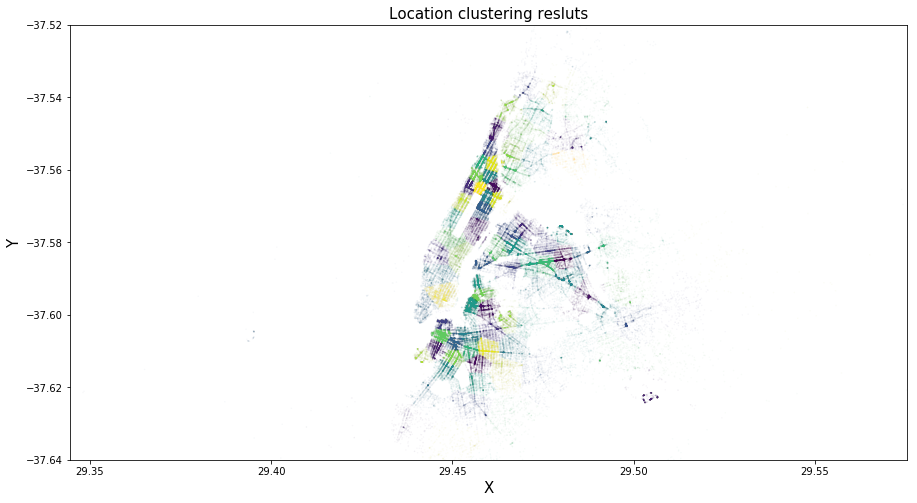

In [37]:
location = location_cluster(pd.concat([X_train,X_test]),cluster_number = 100)   

In [95]:
X_train['Pickup_district'] = location.xs('Pickup', level='Pick_Drop').label.iloc[:X_train.shape[0],]
X_train['Dropoff_district'] = location.xs('Dropoff', level='Pick_Drop').label[:X_train.shape[0],]
X_test['Pickup_district'] = location.xs('Pickup', level='Pick_Drop').label[X_train.shape[0]:,]
X_test['Dropoff_district'] = location.xs('Dropoff', level='Pick_Drop').label[X_train.shape[0]:,]

### Feture Selection

In [38]:
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy
from sklearn.feature_selection import f_regression

def visualize_corvariance(df):
    continue_var = ['Pickup_x','Pickup_y', 'Dropoff_x','Dropoff_y',
                'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
                'Trip_distance', 'Fare_amount', 'Tolls_amount','Speed', 'Tip_amount',
                'Trip_duration','Pickup_hour', 'Dropoff_hour', 'Pickup_weekday', 'Pickup_day','Passenger_count'] 
    X_train_scaled = scale(df[continue_var])
    cov = np.cov(X_train_scaled, rowvar=False)
    order = np.array(hierarchy.dendrogram(hierarchy.ward(cov),no_plot=True)['ivl'], dtype="int")
    plt.figure(figsize=(8, 8), dpi=100)
    plt.imshow(cov[order, :][:, order])
    plt.xticks(range(df[continue_var].shape[1]), [continue_var[i] for i in order], rotation='vertical')
    plt.yticks(range(df[continue_var].shape[1]), [continue_var[i] for i in order]);
    return

# Visualize continuous data
def visualize_numerical(df,y):
    feature_names = ['Pickup_x','Pickup_y', 'Dropoff_x','Dropoff_y',
                'Trip_distance', 'Fare_amount', 'Tolls_amount','Speed', 'Tip_amount',
                'Trip_duration','Pickup_hour', 'Pickup_weekday', 'Pickup_day','Passenger_count'] 
    
    position = {}
    boundary = {}
    for i, feature in enumerate(feature_names):
        position[feature] = [3,5,i+1]
        if i%5==0:
            if i == 10:
                boundary[feature] = ['left','bottom']
            boundary[feature] = ['left']
    plot_dict ={}  
    fig, ax = plt.subplots(3,5,figsize = (30,20))
    fig.subplots_adjust(hspace=0.5, wspace=0)
    fig.suptitle('Continuous Data vs Tip_percentage',fontsize = 30)

    for i, feature in enumerate(feature_names):
    #     print((i,feature))
        subplot = plt.subplot(position[feature][0],
                          position[feature][1],
                          position[feature][2])
        if feature in boundary and 'left'  in boundary[feature]:
            subplot.set_ylabel('Tip_percentage', fontsize=20)
        plot_dict[feature]=subplot.scatter(df[feature], y, alpha = .03)
        subplot.set_xlabel('{f}'.format(f=feature), fontsize=20)
        subplot.grid(axis='y')
    plt.show()
    return

#### Covariance
<font size = 3.5> We notice that the there are 8 pairs of variables are highly correlated. 

- 4 location pairs: (Dropoff_x, Dropoff_longtitude), (Dropoff_y, Dropoff_latitude), (Pickup_x, Pikup_longtitude), (Pickup_y, Pickup_latitude). These pairs indicate same information, so we dont need to keep them all. Drop one of it would totally be fine. Considering about visualization, we will choose x & y.
- Trip_distance & Trip_duration: The higher trip_distance, the higher fare_amount. Although they are correlated, we still decide to keep them both because they have different information.
- Pickup_hour & Dropoff_hour: Since mostly trip is about 0-2 hours. So it make sense they are highly correlated. Considering that we already have pickup hour and trip duration, it will fully explain dropoff hour. So we drop dropoff_hour
- 2 location pairs: (Pickup_x, Pickup_y), (Dropoff_x, Dropoff_y). Although the higher x is, the lower y is. But the combination of them represent location. So we keep them both.

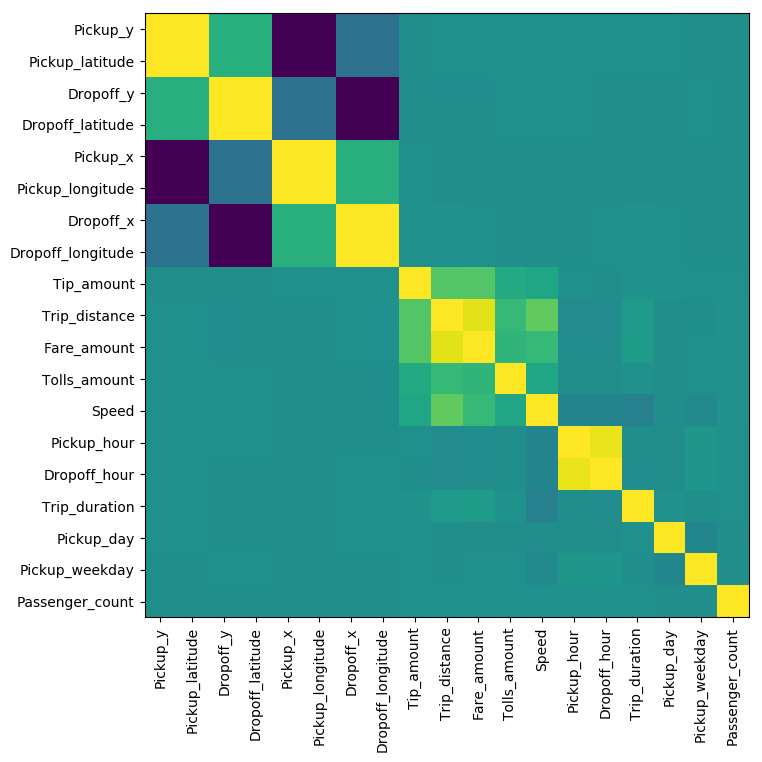

In [39]:
visualize_corvariance(X_train)

#### Visualize numerical data

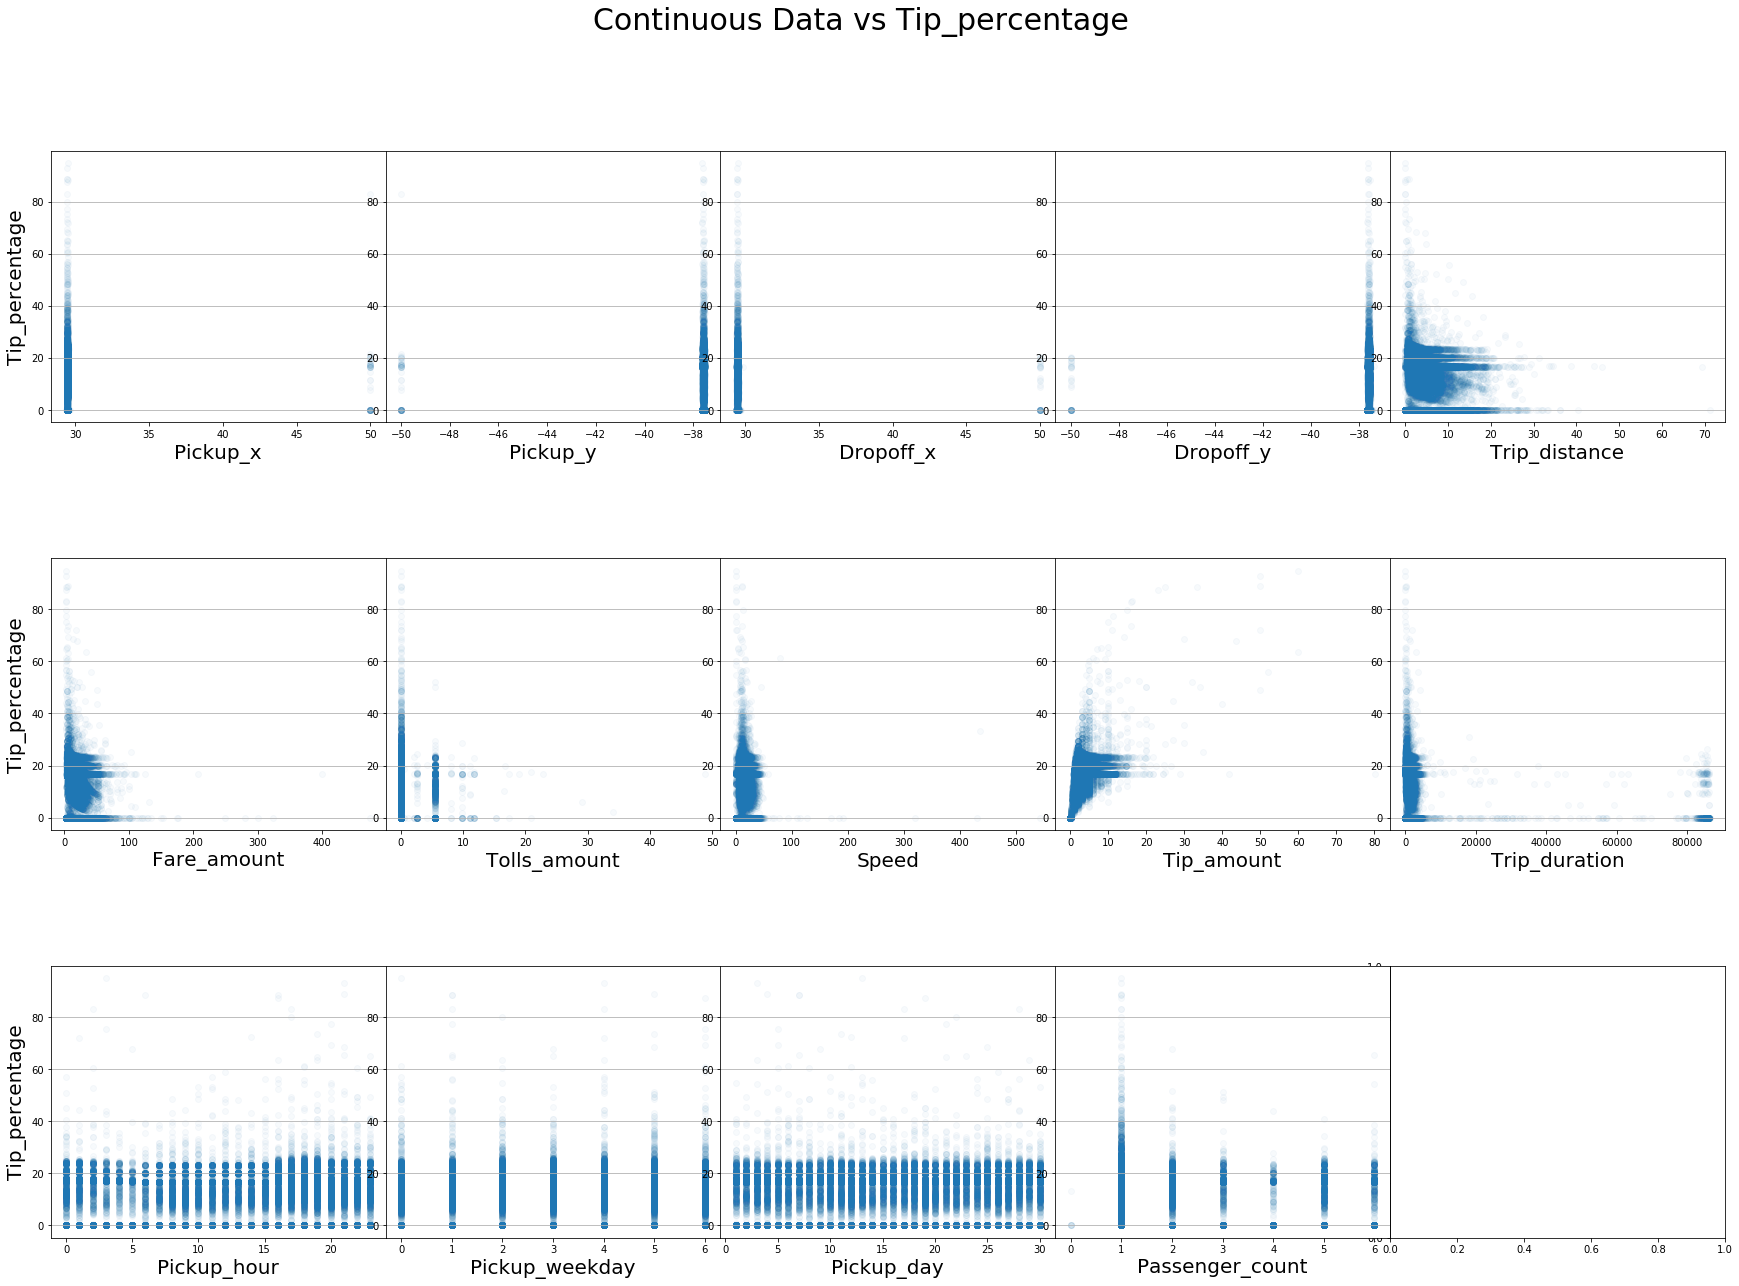

In [40]:
visualize_numerical(X_train,y_train)

#### Categorical data Onehot Encoding

In [41]:
categorical_columns = ['VendorID', 'Store_and_fwd_flag', 'RateCodeID', 'Payment_type',
       'Trip_type ', 'Airport_trip']
#                        ,'Pickup_district','Dropoff_district']
select_columns = ['VendorID', 
       'Store_and_fwd_flag', 'RateCodeID',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tolls_amount', 'improvement_surcharge', 'Payment_type',
       'Trip_type ', 'Pickup_day', 'Pickup_hour', 
       'Pickup_weekday', 'Workday', 'Trip_duration', 'Pickup_x', 'Pickup_y',
       'Dropoff_x', 'Dropoff_y', 'Airport_trip', 'Speed']
# ,'Pickup_district','Dropoff_district']
X_train_dummies = pd.get_dummies(X_train[select_columns], columns=categorical_columns)

<font size = 3.5> Ensure test set has the same one hot encoding way as train set

In [42]:
raw_categorical_columns = ['VendorID', 'Store_and_fwd_flag', 'RateCodeID', 'Payment_type',
       'Trip_type ']
raw_select_columns = ['VendorID', 
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
        'Tolls_amount', 'improvement_surcharge', 'Payment_type',
       'Trip_type ']
raw_X_train_dummies = pd.get_dummies(X_train_raw[raw_select_columns], columns=raw_categorical_columns)
raw_X_test_dummies = pd.get_dummies(X_test[raw_select_columns], columns = raw_categorical_columns)
drop_test_names = [c for c in raw_X_test_dummies.columns if c not in raw_X_train_dummies.columns]
print('Features that occur in test but not in raw train set:',drop_test_names)
add_to_test_names = [c for c in raw_X_train_dummies.columns if c not in raw_X_test_dummies.columns] 
print('Features that occur in train but not in raw test set:',add_to_test_names)

Features that occur in test but not in raw train set: []
Features that occur in train but not in raw test set: ['Payment_type_5']


In [43]:
X_test_dummies = pd.get_dummies(X_test[select_columns], columns = categorical_columns)
drop_test_names = [c for c in X_test_dummies.columns if c not in X_train_dummies.columns]
print('Features that occur in test but not in train set:',drop_test_names)
add_to_test_names = [c for c in X_train_dummies.columns if c not in X_test_dummies.columns] 
print('Features that occur in train but not in test set:',add_to_test_names)

Features that occur in test but not in train set: []
Features that occur in train but not in test set: ['Payment_type_5', 'Airport_trip_1']


In [44]:
X_test_dummies['Airport_trip_1'] = 0
X_test_dummies['Payment_type_5'] = 0
raw_X_test_dummies['Payment_type_5'] = 0

#### make label discrete

In [45]:
y_train_class = y_train.apply(lambda x: 1 if x else 0)
y_test_class = y_test.apply(lambda x: 1 if x else 0)

## 4.2.3 Model Construction and Evaluation
<font size = 3.5>

### Assumptions:
- We assume trips' tip percentage of trips are independent.

### Model Decription: 

Different applications will lead to different evaluation metrics for our model. Considering about this, we assume some situations where our models could be applied:

1. Track trips that will have no tips. In reality, people will pay tips in most situation. So we want to calssify a trip if it will not have tip and figure out what happen.
- Suggest a possible tip percentage for a trip. Since different trips may provided passengers different experiences. So the suggested tip percentage could be different. It saves passengers' time to calculate it.
- Find key features that contribute to high tip percentage. We could also provide these information to taxi company.

### Model Construction:

Given a trip information without tip amount and total amount information, we could build 2 models to solve the problems above. 
1. The **classification** model to predict whether a trip would have tips or not.
    - Baseline Model: Baseline Model would use the basic RF for clean data.(No Feature preprocessing)
    - Imbalanced data: We noticed the data are imbalanced that only 0.15 of them has no tips. There are several ways to deal it, like undersampling, changing thresholds, and changing class weight. Here, we just change class weight, so that it will put more weights on error for less common data. Of course, we would explore other methods or mix of them if we have more time.
    - Tree Models: According to our assumptions that tip percentage are independent, we focus more on features other other than previous tip percentage. Considering there is no obvious linear relationship and there are some outliers in our data, so tree models would be a good choice. As we want to make model interpretable and get feature importance of classifier, some networks models are not suitable. In this case we could try random forest classifier in sklearn.
    - Key Parameters: n_estimators, max_features. In this part we just tune n_estimators. (the auc_ruc is high enough)
    - Evaluation: Our data is imbalanced, there is no meaning for us to look at accuracy. We will look at ROC_AUC and average_precision. If there is a particular requirement on Recall or Precision, we could also take it as one of metrics.
    
2. The **regression** model to predict tip percentage of a trip.
    - Baseline Model: Baseline Model would use the basic RandomForestRegressor for clean data.(No Feature preprocessing)
    - Tree Models: We apply RandomForestRegressor model. The reason are the same as above. We could also apply GradientBoostingRegressor if we have more time.
    - Key Parameters: n_estimators, learning rate, max_features, max_depth. In this part, we just tune n_estimators.
    - Evaluation: We would use $R^2$ as our metric. It's easy for us to know the scale and easy to interpret.
    
### Model Evaluation:

1. Classification:
    - Baseline ROC_AUC: 0.894
    - Our model ROC_AUC: 0.966

- Regression:
    - Baseline $R^2$: 0.616
    - Our model $R^2$: 0.689

- Feature Importance: Payment_type

    We notice Payment_type makes a big difference in both model, so we explore deeper and find only 2 trips have tips in cash trips, which is impossible in reality. And according to description of 'Payment_type' in data dictionary, the total amount will not include tip if the passenger paid in cash. So we assume that it's high likely that it didn't record cash tips.

In [46]:
X_train_dummies.columns

Index(['Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tolls_amount', 'improvement_surcharge', 'Pickup_day', 'Pickup_hour',
       'Pickup_weekday', 'Workday', 'Trip_duration', 'Pickup_x', 'Pickup_y',
       'Dropoff_x', 'Dropoff_y', 'Speed', 'VendorID_1', 'VendorID_2',
       'Store_and_fwd_flag_N', 'Store_and_fwd_flag_Y', 'RateCodeID_1',
       'RateCodeID_2', 'RateCodeID_3', 'RateCodeID_4', 'RateCodeID_5',
       'Payment_type_1', 'Payment_type_2', 'Payment_type_3', 'Payment_type_4',
       'Payment_type_5', 'Trip_type _1.0', 'Trip_type _2.0', 'Airport_trip_0',
       'Airport_trip_1', 'Airport_trip_2', 'Airport_trip_4'],
      dtype='object')

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [53]:
params = {'n_estimators': [50, 100, 130, 150]}
rf = RandomForestClassifier(class_weight = 'balanced',
                            oob_score=True,max_depth = 10)
rf_baseline = RandomForestClassifier(class_weight = 'balanced')

grid_classifier = GridSearchCV(rf,
                    param_grid= params,
                    scoring = 'roc_auc',
                    return_train_score = True)

In [54]:
rf_baseline.fit(raw_X_train_dummies, y_train_class)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [55]:
from sklearn.metrics import roc_auc_score
predict  = rf_baseline.predict(raw_X_test_dummies)
print('The ROC of baseline model is:',roc_auc_score(y_test_class, predict))

The ROC of baseline model is: 0.8942083335565568


In [56]:
grid_classifier.fit(X_train_dummies, y_train_class)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 130, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

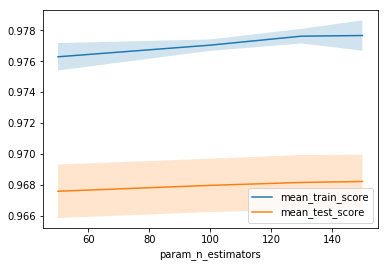

In [57]:
results = pd.DataFrame(grid_classifier.cv_results_)
results.plot('param_n_estimators', 'mean_train_score')
results.plot('param_n_estimators', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_n_estimators.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_n_estimators.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
# plt.xlabel(model)
plt.legend()

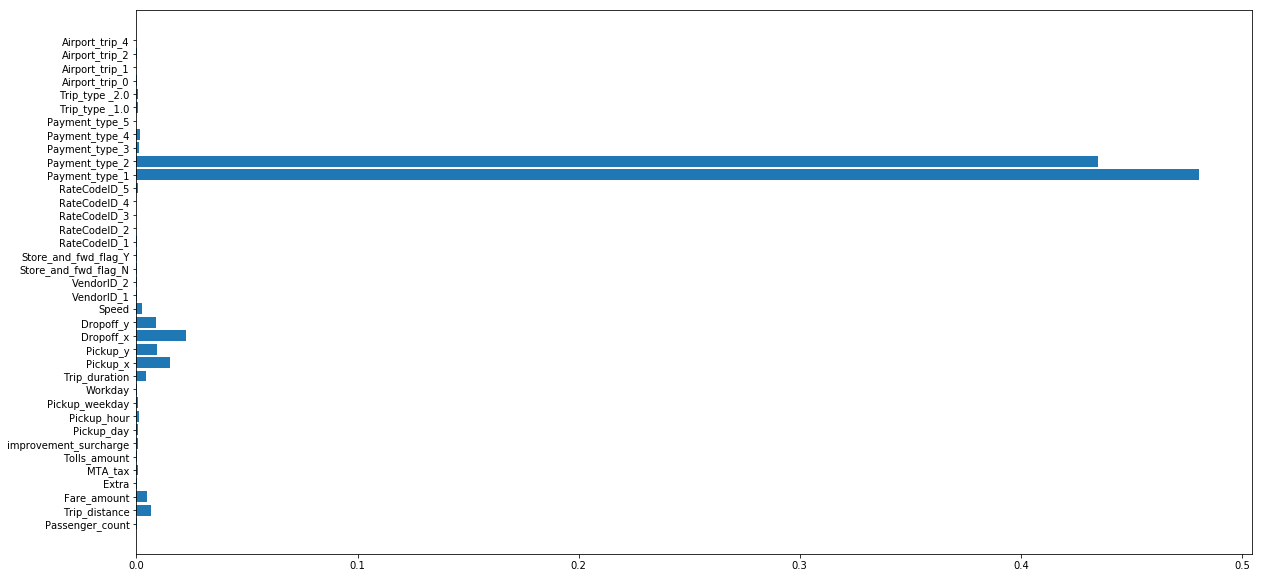

In [58]:
fig, ax = plt.subplots(figsize = (20,10))
# fig.subplots_adjust(hspace=0.5, wspace=0)
plt.barh(range(X_train_dummies.shape[1]),grid_classifier.best_estimator_.feature_importances_)
plt.yticks(range(X_train_dummies.shape[1]),X_train_dummies.columns);

In [59]:
grid_classifier.best_params_

{'n_estimators': 150}

In [60]:
print('The ROC of our model is:',grid_classifier.score(X_test_dummies, y_test_class))

The ROC of our model is: 0.9663317449022933


### Regression Model

In [62]:
rfr_baseline = RandomForestRegressor()
params = {'n_estimators': [50, 100, 130, 150]}
grid = GridSearchCV(RandomForestRegressor(oob_score = True),
                    param_grid= params,
                    return_train_score = True)

In [63]:
rfr_baseline.fit(X_train_dummies,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [65]:
print('The score of our baseline model is:', rfr_baseline.score(X_test_dummies,y_test))

The score of our baseline model is: 0.615870955492292


In [66]:
grid.fit(X_train_dummies,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 130, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

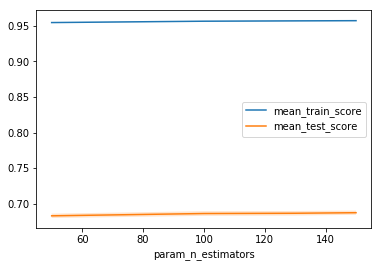

In [67]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_n_estimators', 'mean_train_score')
results.plot('param_n_estimators', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_n_estimators.astype(np.float),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_n_estimators.astype(np.float),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
# plt.xlabel(model)
plt.legend()

In [68]:
print('The score of our model is:', grid.score(X_test_dummies,y_test))

The score of our model is: 0.6885923231722658


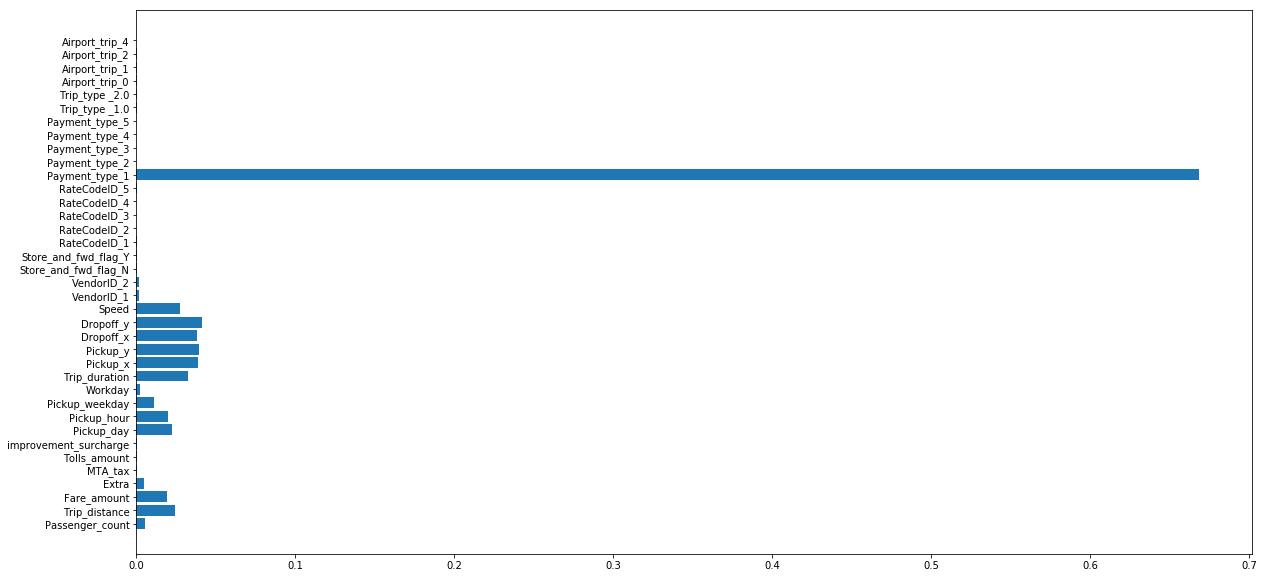

In [69]:
fig, ax = plt.subplots(figsize = (20,10))
# fig.subplots_adjust(hspace=0.5, wspace=0)
plt.barh(range(X_train_dummies.shape[1]),grid.best_estimator_.feature_importances_)
plt.yticks(range(X_train_dummies.shape[1]),X_train_dummies.columns);

In [70]:
params = {'randomforestregressor__n_estimators': [50, 100, 130]}
rf_poly = make_pipeline(PolynomialFeatures(include_bias = False),
                        RandomForestRegressor(oob_score=True))
grid_poly = GridSearchCV(rf_poly,
                    param_grid= params,
                    return_train_score = True)

In [72]:
grid_poly.fit(X_train_dummies,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_imp...stimators=10, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__n_estimators': [50, 100, 130]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [73]:
grid_poly.score(X_test_dummies,y_test)

0.6794235925855081

<font size = 3.5> **Missing tip amount in cash trips**</font>

According to **Payment_type** feature in data dictionary: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf, we noticed that if passengers paid in cash, the total amount will not include tip, which means it's high likely that passengers paid some tips but it didn't record. So we look into these trips to verify our hypothesis.

In [11]:
check_discrete_feature('Payment_type',data)
print('----Tip amount value counts of trips paid by cash----')
print(data[data.Payment_type==2].Tip_amount.value_counts())

-------------Payment_type value counts-------------
   Payment_type  Counts  Proportion
0             2  783699      0.5242
1             1  701287      0.4691
2             3    5498      0.0037
3             4    4368      0.0029
4             5      74      0.0000
----Tip amount value counts of trips paid by cash----
0.00      783697
13.26          1
150.00         1
Name: Tip_amount, dtype: int64
